In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Tweets.csv")

In [3]:
review_df = df[['text','airline_sentiment']]
print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']
print(review_df.shape)
review_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [6]:
review_df["airline_sentiment"].value_counts()

,count
airline_sentiment,
negative,9178
positive,2363


In [7]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [8]:
tweet = review_df.text.values

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

In [10]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding

# Calculate vocab size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1  # ✅ This is the missing part

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, 200))

print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │       423,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440,139 (1.68 MB)

 Trainable params: 440,139 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 198s 659ms/step - accuracy: 0.7760 - loss: 0.5352 - val_accuracy: 0.9017 - val_loss: 0.2375
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 195s 648ms/step - accuracy: 0.8905 - loss: 0.2829 - val_accuracy: 0.9138 - val_loss: 0.2139
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 206s 662ms/step - accuracy: 0.9117 - loss: 0.2295 - val_accuracy: 0.9142 - val_loss: 0.2100
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 199s 651ms/step - accuracy: 0.9336 - loss: 0.1787 - val_accuracy: 0.9229 - val_loss: 0.1934
Epoch 5/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 201s 647ms/step - accuracy: 0.9461 - loss: 0.1462 - val_accuracy: 0.9177 - val_loss: 0.2102


In [14]:
model.save("/content/drive/MyDrive/sentiment_model.keras")


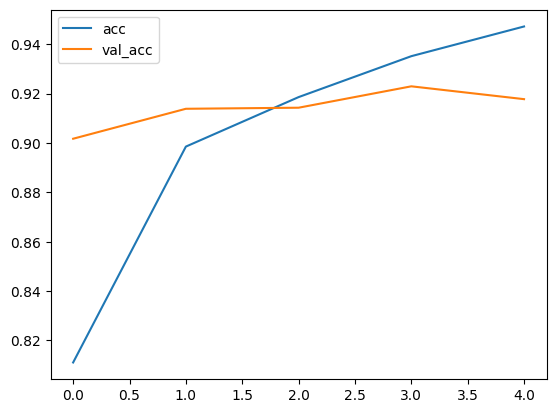

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

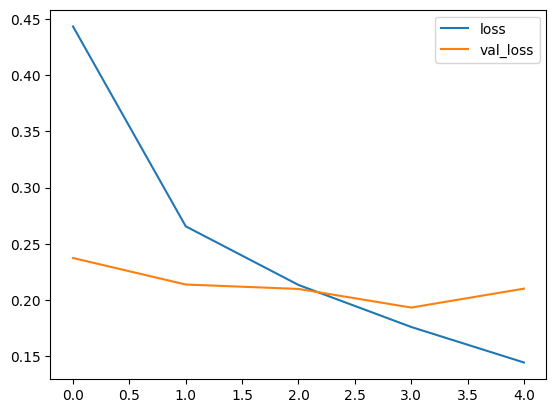

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [17]:
import pickle
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [19]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "Priyanka is a good girl"
predict_sentiment(test_sentence1)

test_sentence2 = "Awesome experience! Loved it."
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predicted label:  positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted label:  positive
